In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import scipy as scp
from sklearn.decomposition import PCA
from sklearn import preprocessing

### Load data: features and stability scores

In [2]:
features_df = pd.read_csv('./20180108_features_20190210.csv',index_col=0)
Stability_df = pd.read_csv('./all_des_stability_scores.csv',index_col=0)

### Do some bookkeeping

In [3]:
renaming_dict = {'BBM1pem':'Mk1.PeCH','BBMHCYm':'Mk1.PaCH.Cort',\
           'BB47nHm':'4B.7','BBM1pam':'Mk1.PaCH',\
           'BB45CHm':'4B.5.CH','BBM1TPm':'Mk1.TP',\
           'BB47CHm':'4B.7.CH','BBM2nHm':'Mk2',\
           'BBM1nHm':'Mk1','BB45nHm':'4B.5',\
           'scBB45nHm':'scrambles','scBB47CHm':'scrambles',\
           'scBB47nHm':'scrambles','scBBM1TPm':'scrambles',\
           'scBBM1nHm':'scrambles','scBBM1pem':'scrambles',\
           'scBBM2nHm':'scrambles','scBBMHCYm':'scrambles',\
           'scBB45CHm':'scrambles','scBBM1pam':'scrambles'}
selected = [ i for i in Stability_df.index.values if any([ (key in i) for key in renaming_dict.keys()]) ]
Stability_df_clean = Stability_df.loc[selected]
Stability_df_clean['subfam'] = np.array([ renaming_dict[i[:-4]] for i in Stability_df_clean.index])

In [4]:
# Remove undesired entries and consolidate data:
features_clean = features_df[[i for i in features_df.columns if i!='stability_score']].loc[features_df.index.intersection(Stability_df_clean.index)]

features_clean['subfam'] = Stability_df_clean.loc[Stability_df_clean.index.intersection(features_clean.index)]['subfam'].values
features_clean['stability_score'] = Stability_df_clean.loc[Stability_df_clean.index.intersection(features_clean.index)]['stability_sc'].values
features_clean.to_csv('./chip1_clean_features2.csv')



### Set up for training 

In [5]:
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV,ElasticNet,Lasso
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import scale, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [6]:
BB_df = features_clean
terms_given_C={}
allterms = [i for i in BB_df.columns if (i !='stability_score') and (i !='subfam') ]
scaler = StandardScaler()
scaler.fit(BB_df[allterms])
X=scaler.transform(BB_df[allterms])
y = [ x > 1.0 for x in BB_df['stability_score'].values]

In [7]:
# List of regularization constants for Lasso:
Cs = [0.05, 0.045,0.04, 0.035,0.03, 0.025,0.02, 0.01,0.008,0.005,0.0048,0.004]

result_summary = {}
for C in Cs:
    result_summary[C] = {}
    for randstate in range(40):
        # Make a different split each time:
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=randstate)
        clf = LogisticRegression(C=C,penalty='l1',class_weight='balanced',random_state=1,solver='liblinear')
        clf.fit(X_train,y_train)
        #C_lists.append(C)
        
        train_proba = [x[1] for x in clf.predict_proba(X_train)]
        test_proba = [x[1] for x in clf.predict_proba(X_test)]
        fpr,tpr,thresholds=roc_curve(y_train,train_proba)
        #plt.plot(fpr,tpr,label=C)
        
        
        terms_n = sum([x != 0 for x in clf.coef_[0]])
        train_auc = roc_auc_score(y_train,train_proba)
        test_auc = roc_auc_score(y_test,test_proba)
        train_score = clf.score(X_train,y_train)
        test_score = clf.score(X_test,y_test)
        train_accuracy = recall_score(y_train,clf.predict(X_train))
        test_accuracy = recall_score(y_test,clf.predict(X_test))
        #print ('C=%s  terms:%s  train_auc=%.3f test_auc=%.3f score_train=%.3f score_test=%.3f, train_acc=%.3f, test_acc=%.3f' %(C,terms_n,train_auc,test_auc,train_score,test_score,train_accuracy,test_accuracy))
        result_summary[C][randstate] = {'test_score':test_score,'test_accuracy':test_accuracy,\
                                        'train_score':train_score,'train_accuracy':train_accuracy,\
                                       'test_auc':test_auc,'train_auc':train_auc,'non_zero_terms':[]}
        
        for coef, term in zip(clf.coef_[0], allterms):
            if coef != 0.0: result_summary[C][randstate]['non_zero_terms'].append((coef,term))

### Plot results

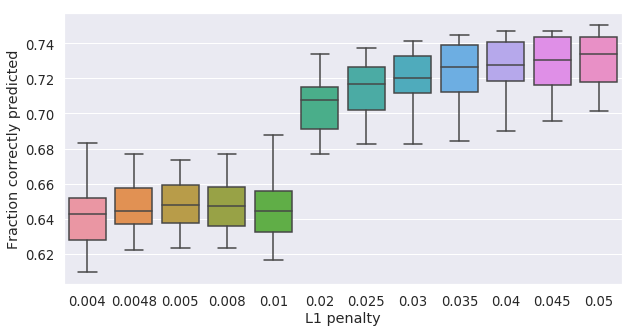

In [8]:
C_vals = sorted([i for i in result_summary.keys()])
C_20_vals = []
test_scores = []
train_scores = []
test_auc_list = []
train_auc_list = []
for i in C_vals:
    for j in range(20):
        C_20_vals.append(i)
        test_scores.append(result_summary[i][j]['test_score'])
        train_scores.append(result_summary[i][j]['train_score'])
        test_auc_list.append(result_summary[i][j]['test_auc'])
        train_auc_list.append(result_summary[i][j]['train_auc'])

sns.set(font_scale=1.2)
fig1,ax1= plt.subplots(1,figsize=(10,5))
#sns.boxplot(np.array(C_20_vals),np.array(test_auc_list))
#plt.legend()
#plt.show()
sns.boxplot(np.array(C_20_vals),np.array(test_scores),ax=ax1)
ax1.set_xlabel('L1 penalty')
ax1.set_ylabel('Fraction correctly predicted')
plt.show()

### Get simplest model
Looks like around L1=0.02 the model performance reaches a plateau, so we are going to look for the simplest model at that value that has a score within one standard deviation of the mean for models with that L1

In [11]:
for i in range(40):
    print(i,len(result_summary[0.02][i]['non_zero_terms']),result_summary[0.02][i]['test_score'])
print('Average n features: %d'%(np.average([len(result_summary[0.02][i]['non_zero_terms']) for i in range(40)])))

0 16 0.7281879194630873
1 21 0.714765100671141
2 16 0.6912751677852349
3 15 0.7158836689038032
4 18 0.7214765100671141
5 21 0.6789709172259508
6 18 0.714765100671141
7 18 0.7337807606263982
8 17 0.70917225950783
9 16 0.7058165548098434
10 17 0.6968680089485458
11 15 0.6767337807606264
12 21 0.7114093959731543
13 18 0.6901565995525727
14 17 0.697986577181208
15 15 0.6890380313199105
16 17 0.6767337807606264
17 20 0.7125279642058165
18 17 0.7181208053691275
19 16 0.6968680089485458
20 14 0.7058165548098434
21 20 0.6868008948545862
22 13 0.6767337807606264
23 14 0.6845637583892618
24 17 0.6789709172259508
25 15 0.6957494407158836
26 18 0.7125279642058165
27 17 0.7214765100671141
28 12 0.6845637583892618
29 18 0.6923937360178971
30 15 0.7046979865771812
31 19 0.6957494407158836
32 14 0.6901565995525727
33 19 0.7080536912751678
34 20 0.6756152125279642
35 17 0.6868008948545862
36 15 0.6767337807606264
37 17 0.7058165548098434
38 14 0.6812080536912751
39 18 0.7080536912751678
Average n featu

In [12]:
# The simplest model is random partition=23, lets look at it:
for i in sorted(result_summary[0.02][28]['non_zero_terms'],key=lambda x:abs(x[0]),reverse=True):
    print(i)

(-0.4327745732156281, 'score_res_betacart')
(0.23140497215243389, 'hydrophobicity')
(-0.21008144345515026, 'avAll')
(0.19975656796922642, 'hphob_sc_contacts')
(0.13640176089476325, 'nres_hydrophob_noA_per')
(0.12195996754097503, 'str5_6_ssc50_worst')
(-0.11821112159575972, 'fa_sol')
(-0.08739678765277338, 'H3_av_worstfr')
(-0.06984506642279237, 'buns_nosurf_sc')
(0.05049736997681972, 'BuriedHyphobSAperRes')
(0.030453349382360783, 'H3_ssc50_worst')
(-0.003539204199508975, 'H3_n_av_worstfr')


### Get feature importance

In [13]:
terms = []
for i in range(40):
    for j in result_summary[0.02][i]['non_zero_terms']:
        terms.append(j[1])

didt_for_df = {i:{ j:0 for j in terms} for i in range(40)}
        
for i in range(40):
    for j in result_summary[0.02][i]['non_zero_terms']:
        didt_for_df[i][j[1]] = j[0]
        #didt_for_df[i][j[1]] = abs(j[0])

models_df = pd.DataFrame.from_dict(didt_for_df,orient='index')

/software/conda/envs/pyrosetta/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


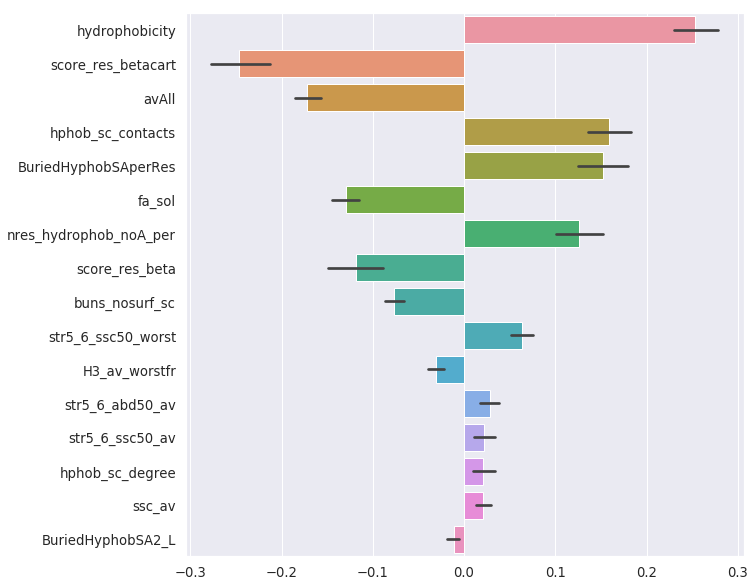

In [14]:
fig2,ax2= plt.subplots(1,figsize=(10,10))
sorted_terms_by_av = sorted( [(t,abs(np.average(models_df[t]))) for t in set(terms)], key=lambda x:x[1]  )
top_16_terms = [i for i in reversed([t[0] for t in sorted_terms_by_av][-16:])]
sns.barplot(data=models_df[top_16_terms],orient='h',ax=ax2)
#ax2.set_xlabel('Features')
#ax2.set_ylabel('Weight absolute value')
plt.show()

### Get correlation matrix for simplest model

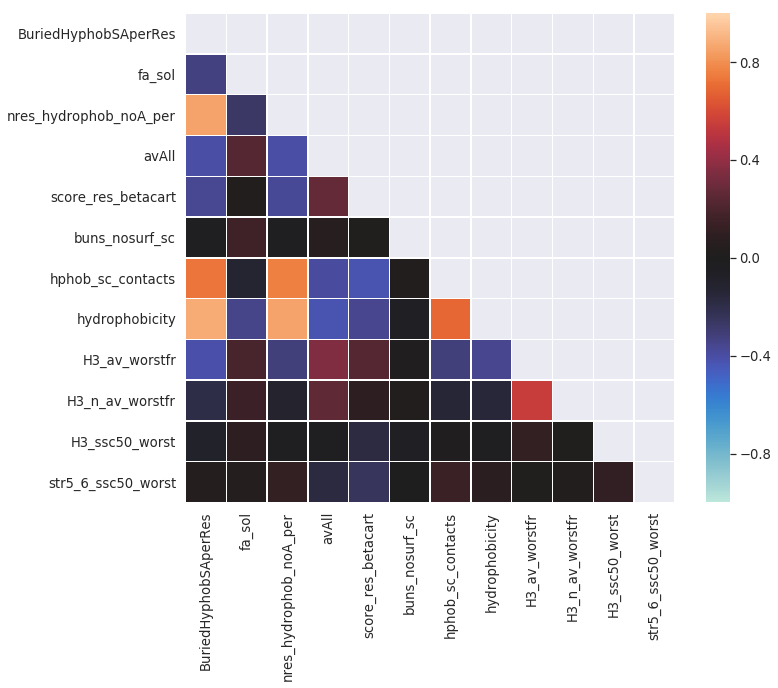

In [15]:
simplest_model_features = [i[1] for i in result_summary[0.02][28]['non_zero_terms']]
specific_df = features_clean[simplest_model_features]
corr = specific_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5)

### Get correlation matrix for 16 most important features in all (40) models

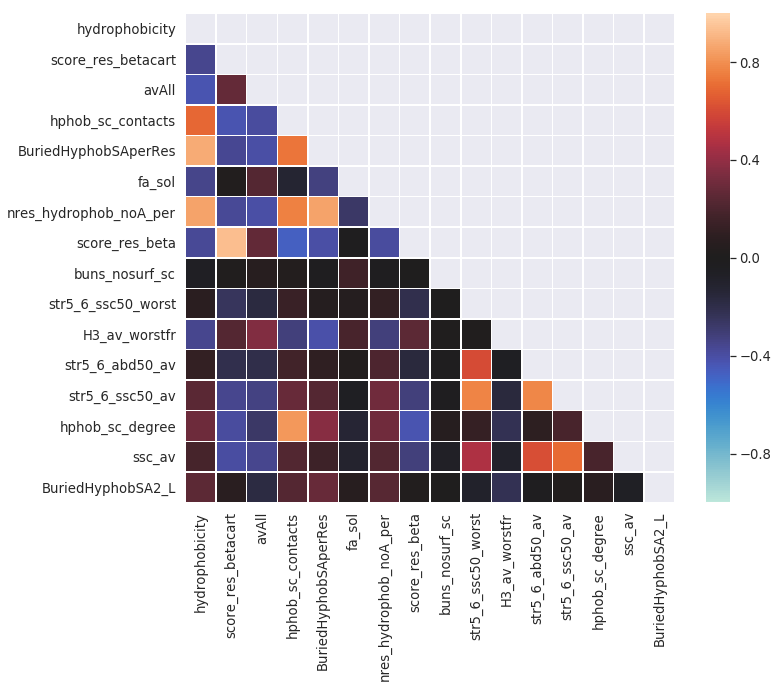

In [16]:
specific_df = features_clean[top_16_terms]
corr = specific_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5)

### What are the less complex models at L1<0.005?

In [17]:
for i in range(40):
    print(i,len(result_summary[0.005][i]['non_zero_terms']),result_summary[0.005][i]['test_score'])
print('Average n features: %d'%(np.average([len(result_summary[0.005][i]['non_zero_terms']) for i in range(40)])))

0 5 0.6711409395973155
1 5 0.6577181208053692
2 4 0.6387024608501118
3 6 0.6554809843400448
4 4 0.6521252796420581
5 5 0.6230425055928411
6 6 0.6409395973154363
7 5 0.6733780760626398
8 5 0.6543624161073825
9 5 0.668903803131991
10 6 0.6633109619686801
11 5 0.6342281879194631
12 6 0.6633109619686801
13 4 0.6241610738255033
14 5 0.6420581655480985
15 4 0.6387024608501118
16 4 0.6342281879194631
17 6 0.6510067114093959
18 5 0.6442953020134228
19 4 0.6308724832214765
20 4 0.639821029082774
21 6 0.6331096196868009
22 5 0.616331096196868
23 4 0.6208053691275168
24 5 0.62751677852349
25 5 0.6420581655480985
26 4 0.6487695749440716
27 5 0.6431767337807607
28 4 0.6353467561521253
29 6 0.6364653243847874
30 4 0.645413870246085
31 4 0.6409395973154363
32 6 0.6297539149888143
33 6 0.6510067114093959
34 5 0.6241610738255033
35 5 0.6308724832214765
36 5 0.6319910514541387
37 5 0.656599552572707
38 6 0.6196868008948546
39 5 0.6342281879194631
Average n features: 4


In [18]:
# The simplest model is random partition=4, lets look at it:
for i in sorted(result_summary[0.005][4]['non_zero_terms'],key=lambda x:abs(x[0]),reverse=True):
    print(i)

(0.2071072712129005, 'nres_hydrophob_noA_per')
(0.15736215989141758, 'hydrophobicity')
(-0.11455776540597672, 'score_res_betacart')
(0.034557707315177544, 'hphob_sc_contacts')


In [19]:
# It's mostly hydrophobicity